In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


### Hyperparameters

In [3]:
BATCH_SIZE = 16
N_EPOCHS = 50
LEARNING_RATE = 1e-3
PIN_MEMORY = True
NUM_WORKERS = 0  
BASE_DIR = Path("C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed")
# Mel spectrogram parameters
N_MELS = 80
MEL_MEAN = np.load(BASE_DIR / "mel_mean.npy")
MEL_STD = np.load(BASE_DIR / "mel_std.npy")
# Paths
TRAIN_META = BASE_DIR / "train_metadata.csv"
TEST_META = BASE_DIR / "test_metadata.csv"
NORM_MEL_DIR = BASE_DIR / "normalized"
# Phoneme mappings
phoneme_to_id = np.load(BASE_DIR / "phoneme_to_id.npy", allow_pickle=True).item()
id_to_phoneme = np.load(BASE_DIR / "id_to_phoneme.npy", allow_pickle=True).item()
print("Phoneme vocab size:", len(phoneme_to_id))

Phoneme vocab size: 77


In [4]:
BASE_DIR = Path(r"C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed")
TRAIN_META = BASE_DIR / "train_metadata.csv"
TEST_META = BASE_DIR / "test_metadata.csv"
NORM_MEL_DIR = BASE_DIR / "normalized"
MEL_MEAN = np.load(BASE_DIR / "mel_mean.npy")
MEL_STD = np.load(BASE_DIR / "mel_std.npy")
PHONEME_TO_ID = np.load(BASE_DIR / "phoneme_to_id.npy", allow_pickle=True).item()
ID_TO_PHONEME = np.load(BASE_DIR / "id_to_phoneme.npy", allow_pickle=True).item()


BATCH_SIZE = 16
NUM_WORKERS = 0
PIN_MEMORY = True
N_MELS = 80


CHECKPOINT_DIR = BASE_DIR / "checkpoints"
CHECKPOINT_DIR.mkdir(exist_ok=True)

### Build Speaker Map

In [5]:
# Load train + test metadata
train_meta = pd.read_csv(TRAIN_META)
test_meta = pd.read_csv(TEST_META)

# Use ALL speakers from train + test
all_df = pd.concat([train_meta, test_meta])
speakers = sorted(all_df["speaker"].astype(str).unique().tolist())
spk2idx = {s: i for i, s in enumerate(speakers)}

print(f"Speakers found: {len(spk2idx)}")


Speakers found: 247


In [6]:
train_df = pd.read_csv(TRAIN_META)
test_df = pd.read_csv(TEST_META)


all_speakers = sorted(set(train_df["speaker"].astype(str)).union(set(test_df["speaker"].astype(str))))
spk2idx = {s:i for i,s in enumerate(all_speakers)}
idx2spk = {i:s for s,i in spk2idx.items()}
NUM_SPK = len(spk2idx)
print(f"Built spk2idx from union. Found {NUM_SPK} speakers.")

Built spk2idx from union. Found 247 speakers.


### DATASET LOADER

In [5]:
class TTSDataset(Dataset):
    def __init__(self, metadata_path, phoneme_to_id, spk2idx, sr=22050, max_len=800):
        self.df = pd.read_csv(metadata_path)
        self.phoneme_to_id = phoneme_to_id
        self.spk2idx = dict(spk2idx)  # make a copy
        self.sr = sr
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Phoneme IDs
        phones = str(row["phonemized"]).split()
        phone_ids = [self.phoneme_to_id[p] for p in phones if p in self.phoneme_to_id]

        if len(phone_ids) == 0:  # handle empty cases
            phone_ids = [0]

        # Speaker ID 
        spk = str(row["speaker"])
        if spk in self.spk2idx:
            spk_idx = self.spk2idx[spk]
        else:
            if "unknown" not in self.spk2idx:
                unk_idx = len(self.spk2idx)
                self.spk2idx["unknown"] = unk_idx
                print(f"[WARN] Speaker {spk} not in training set. Assigned to 'unknown' index {unk_idx}.")
            spk_idx = self.spk2idx["unknown"]

        # Normalized mel spectrogram 
        mel_path = os.path.join(NORM_MEL_DIR, row["utt_id"] + ".npy")
        mel = np.load(mel_path)  # (n_mels, frames)
        mel = (mel - MEL_MEAN) / MEL_STD  # normalize
        mel = mel.T  # shape -> (frames, n_mels)

        return {
            "phones": torch.tensor(phone_ids, dtype=torch.long),
            "speaker": torch.tensor(spk_idx, dtype=torch.long),
            "mel": torch.tensor(mel, dtype=torch.float32),
        }


### Collate Function

In [6]:
def collate_fn(batch):
    phones = [b["phones"] for b in batch]
    speakers = [b["speaker"] for b in batch]
    mels = [b["mel"] for b in batch]

    # --- Pad phones ---
    max_phone_len = max(len(p) for p in phones)
    padded_phones = torch.zeros(len(batch), max_phone_len, dtype=torch.long)
    for i, p in enumerate(phones):
        padded_phones[i, :len(p)] = p

    # --- Pad mel spectrograms ---
    max_mel_len = max(m.shape[0] for m in mels)
    padded_mels = torch.zeros(len(batch), max_mel_len, mels[0].shape[1], dtype=torch.float32)
    for i, m in enumerate(mels):
        padded_mels[i, :m.shape[0], :] = m

    speakers = torch.stack(speakers)

    return {
        "phones": padded_phones,
        "speaker": speakers,
        "mel": padded_mels,
    }


### Datasets & Dataloaders

In [7]:
train_dataset = TTSDataset(TRAIN_META, phoneme_to_id, spk2idx)
test_dataset  = TTSDataset(TEST_META, phoneme_to_id, spk2idx)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, pin_memory=PIN_MEMORY, num_workers=NUM_WORKERS
)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


Train batches: 1819, Test batches: 259


In [8]:
batch = next(iter(train_loader))
print("Phones:", batch["phones"].shape)
print("Speakers:", batch["speaker"].shape)
print("Mels:", batch["mel"].shape)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ADMIN\\Downloads\\SSP\\VoiceProject\\processed\\normalized\\7505_258964_000009_000000.npy'

In [9]:
import pandas as pd

df = pd.read_csv("C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/train_metadata.csv")
print(df.head())

                   utt_id                                               text  \
0  103_1241_000000_000001                      matthew cuthbert is surprised   
1  103_1241_000004_000002  in fact, he had looked at twenty very much as ...   
2  103_1241_000007_000001  "but there was a passenger dropped off for you...   
3  103_1241_000008_000001                         "it's a boy i've come for.   
4  103_1241_000012_000002  maybe they were out of boys of the brand you w...   

   speaker                                               path  \
0      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...   
1      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...   
2      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...   
3      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...   
4      103  G:\Libri Dataset\LibriTTS\train-clean-100\103\...   

                                          phonemized  split  
0  M AE1 TH Y UW0 K AH1 TH B ER0 T IH1 Z S ER0 P ...  train  
1  I

In [10]:
import os

mel_path = "C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed/normalized/7505_258964_000009_000000.npy"
print(os.path.exists(mel_path))

False


In [11]:
SR = 22050
N_MELS = 80
N_FFT = 1024
HOP_LENGTH = 256

BASE_DIR = Path("C:/Users/ADMIN/Downloads/SSP/VoiceProject/processed")
TRAIN_META = BASE_DIR / "train_metadata.csv"
TEST_META = BASE_DIR / "test_metadata.csv"
NORM_MEL_DIR = BASE_DIR / "normalized"
NORM_MEL_DIR.mkdir(parents=True, exist_ok=True)

# Load mel stats
MEL_MEAN = np.load(BASE_DIR / "mel_mean.npy")
MEL_STD = np.load(BASE_DIR / "mel_std.npy")

In [16]:
import sys
!{sys.executable} -m pip install librosa

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 4.2 MB/s eta 0:00:01
   ------------------ --------------------- 1.3/2.8 MB 3.0 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 3.0 MB/s eta 0:00:01
   ------------------------------------- -- 2.6/2.8 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
    --------------------------------------- 0.5/30.3 MB 4.2 MB/s eta 0:00:08
   - -------------------------------------- 1.3/30.3 MB 2.9 MB/s eta 0:00:10
   -- ------------------------------------- 1.8/30.3 MB 3.0 MB/s eta 0:00:10
   --- ------------------------------------ 2.6/30.3 MB 3.1 MB/s eta 0:00:09
   ---- ----------------------------------- 3.1/30.3 MB 3.0 MB/s eta 0:00:09
   ----- ------------------

In [17]:
import librosa
def wav_to_mel(wav_path):
    wav, _ = librosa.load(wav_path, sr=SR)
    mel = librosa.feature.melspectrogram(
        y=wav,
        sr=SR,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_norm = (mel_db - MEL_MEAN) / MEL_STD
    return mel_norm

def process_and_save(meta_path):
    df = pd.read_csv(meta_path)
    mel_paths = []

    for i, row in df.iterrows():
        wav_path = row["path"]
        mel = wav_to_mel(wav_path)

        # Save one file per utterance
        mel_file = NORM_MEL_DIR / f"{row['id']}.npy"
        np.save(mel_file, mel.astype(np.float32))
        mel_paths.append(str(mel_file))

        if i % 200 == 0:
            print(f"Processed {i}/{len(df)} files")

    # Add mel_path column
    df["mel_path"] = mel_paths
    df.to_csv(meta_path, index=False)
    print(f"Updated metadata with mel_path saved to {meta_path}")

# Run for train and test
process_and_save(TRAIN_META)
process_and_save(TEST_META)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10324\231152906.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  wav, _ = librosa.load(wav_path, sr=SR)
C:\Users\ADMIN\anaconda3\envs\torch-gpu\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'G:\\Libri Dataset\\LibriTTS\\train-clean-100\\103\\1241\\103_1241_000000_000001.wav'

### Dataset

In [7]:
SPK_EMB_DIR = BASE_DIR / "spk_embeds" # optional
SPK_EMB_DIM = 256
def try_load_external_spk_embed(spk_id: str):
    p = SPK_EMB_DIR / f"{spk_id}.npy"
    if p.exists():
        v = np.load(p)
        return torch.tensor(v, dtype=torch.float32)
    return None

In [8]:
class TTSDataset(Dataset):
    def __init__(self, metadata_path, mel_dir, phoneme_to_id, spk2idx, mel_mean, mel_std):
        self.meta = pd.read_csv(metadata_path)
        self.mel_dir = Path(mel_dir)
        self.phoneme_to_id = phoneme_to_id
        self.spk2idx = spk2idx
        self.mel_mean = mel_mean.astype(np.float32)
        self.mel_std = mel_std.astype(np.float32)


    def __len__(self):
        return len(self.meta)


    def __getitem__(self, idx):
        row = self.meta.iloc[idx]


        # Phonemes → ids (filter unknowns)
        phones = str(row.get("phonemized", "")).split()
        phone_ids = [self.phoneme_to_id[p] for p in phones if p in self.phoneme_to_id]
        if len(phone_ids) == 0:
        # fallback to a single PAD-like token (id 0 reserved for PAD)
            phone_ids = [0]
        text = torch.tensor(phone_ids, dtype=torch.long)
        # Mel
        utt_id = str(row["utt_id"]) if "utt_id" in row else str(row[0])
        mel_path = self.mel_dir / f"{utt_id}_mel.npy"
        if not mel_path.exists():
            raise FileNotFoundError(f"Missing mel for utt: {utt_id} -> {mel_path}")
        mel = np.load(mel_path) # [T, mel]
        # normalize using precomputed mean/std
        mel = ((mel - self.mel_mean) / (self.mel_std + 1e-8)).astype(np.float32)
        mel = torch.from_numpy(mel)
        # speaker
        spk = str(row["speaker"]) if "speaker" in row else "0"
        spk_idx = self.spk2idx.get(spk, 0) # fallback to 0
        spk_ext = try_load_external_spk_embed(spk)

        return text, mel, spk_idx, spk_ext

### Collate functn

In [9]:
def collate_fn(batch):
    texts, mels, spk_idx, spk_ext = zip(*batch)

    # text padding
    text_lens = [len(t) for t in texts]
    max_tlen = max(text_lens)
    text_pad = torch.zeros(len(batch), max_tlen, dtype=torch.long)
    for i, t in enumerate(texts):
        text_pad[i, :len(t)] = t

    # mel padding
    mel_lens = [m.shape[0] for m in mels]
    max_mlen = max(mel_lens)
    mel_pad = torch.zeros(len(batch), max_mlen, N_MELS, dtype=torch.float32)
    for i, m in enumerate(mels):
        mel_pad[i, :m.shape[0]] = m

    spk_idx = torch.tensor(spk_idx, dtype=torch.long)

    has_any_ext = any([e is not None for e in spk_ext])
    if has_any_ext:
        ext_list = []
        for e in spk_ext:
            if e is None:
                ext_list.append(torch.zeros(SPK_EMB_DIM))
            else:
                ext_list.append(e)
        spk_ext = torch.stack(ext_list, dim=0)
    else:
        spk_ext = None

    return text_pad, torch.tensor(text_lens), mel_pad, torch.tensor(mel_lens), spk_idx, spk_ext


#### dataset + loader

In [10]:
train_ds = TTSDataset(TRAIN_META, NORM_MEL_DIR, PHONEME_TO_ID, spk2idx, MEL_MEAN, MEL_STD)
test_ds = TTSDataset(TEST_META, NORM_MEL_DIR, PHONEME_TO_ID, spk2idx, MEL_MEAN, MEL_STD)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_fn)
print("Dataset sizes -> Train:", len(train_ds), "Test:", len(test_ds))

Dataset sizes -> Train: 29102 Test: 4134


In [11]:
batch = next(iter(train_loader))
text, text_lens, mel, mel_lens, spk_idx, spk_ext = batch
print("Debug batch shapes:")
print(" text:", text.shape, "text_lens:", text_lens.shape)
print(" mel:", mel.shape, "mel_lens:", mel_lens.shape)
print(" spk_idx:", spk_idx.shape, "spk_ext:", None if spk_ext is None else spk_ext.shape)

Debug batch shapes:
 text: torch.Size([16, 138]) text_lens: torch.Size([16])
 mel: torch.Size([16, 1198, 80]) mel_lens: torch.Size([16])
 spk_idx: torch.Size([16]) spk_ext: None


### Model

In [12]:
class Prenet(nn.Module):
    def __init__(self, in_dim, sizes):
        super().__init__()
        layers = []
        for size in sizes:
            layers.append(nn.Linear(in_dim, size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.5))
            in_dim = size
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [13]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, conv_ch=512, K=5, lstm_dim=256):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.convs = nn.Sequential(
            nn.Conv1d(emb_dim, conv_ch, kernel_size=K, padding=(K - 1) // 2),
            nn.ReLU(), nn.BatchNorm1d(conv_ch),
            nn.Conv1d(conv_ch, conv_ch, kernel_size=K, padding=(K - 1) // 2),
            nn.ReLU(), nn.BatchNorm1d(conv_ch),
            nn.Conv1d(conv_ch, conv_ch, kernel_size=K, padding=(K - 1) // 2),
            nn.ReLU(), nn.BatchNorm1d(conv_ch),
        )
        self.bilstm = nn.LSTM(conv_ch, lstm_dim, batch_first=True, bidirectional=True)

    def forward(self, x, lengths):
        x = self.embed(x)                      # [B, T, emb]
        x = x.transpose(1, 2)                  # [B, emb, T]
        x = self.convs(x)                      # [B, conv_ch, T]
        x = x.transpose(1, 2)                  # [B, T, conv_ch]
        x = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        x, _ = self.bilstm(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        return x


In [14]:
class LocationSensitiveAttention(nn.Module):
    def __init__(self, enc_dim, dec_dim, attn_dim=128, loc_filters=32, loc_kernel=31):
        super().__init__()
        self.query_proj = nn.Linear(dec_dim, attn_dim, bias=False)
        self.memory_proj = nn.Linear(enc_dim, attn_dim, bias=False)
        self.v = nn.Linear(attn_dim, 1, bias=False)
        self.location_conv = nn.Conv1d(2, loc_filters, kernel_size=loc_kernel,
                                       padding=(loc_kernel - 1) // 2, bias=False)
        self.location_proj = nn.Linear(loc_filters, attn_dim, bias=False)

    def forward(self, query, memory, attn_prev, cum_attn, mask=None):
        B, T, _ = memory.size()

        processed_memory = self.memory_proj(memory)            # [B, T, A]
        query = self.query_proj(query).unsqueeze(1)            # [B, 1, A]

        loc = torch.stack([attn_prev, cum_attn], dim=1)        # [B, 2, T]
        loc = self.location_conv(loc)                          # [B, F, T]
        loc = loc.transpose(1, 2)                              # [B, T, F]
        loc = self.location_proj(loc)                          # [B, T, A]

        energies = self.v(torch.tanh(processed_memory + query + loc)).squeeze(-1)  # [B, T]

        if mask is not None:
            energies.masked_fill_(~mask, torch.finfo(energies.dtype).min)

        attn = torch.softmax(energies, dim=-1)                 # [B, T]
        context = torch.bmm(attn.unsqueeze(1), memory).squeeze(1)  # [B, enc_dim]

        return context, attn


In [15]:
class Decoder(nn.Module):
    def __init__(self, enc_dim, mel_dim=80, spk_dim=256, dec_dim=1024, prenet_sizes=(256, 256)):
        super().__init__()
        self.prenet = Prenet(mel_dim, prenet_sizes)
        self.attn_rnn = nn.LSTMCell(prenet_sizes[-1] + spk_dim + enc_dim, dec_dim)
        self.attn = LocationSensitiveAttention(enc_dim, dec_dim)
        self.decoder_rnn = nn.LSTMCell(dec_dim + enc_dim, dec_dim)
        self.mel_proj = nn.Linear(dec_dim + enc_dim, mel_dim)
        # IMPORTANT: return logits (no sigmoid) to be compatible with BCEWithLogitsLoss
        self.stop_proj = nn.Linear(dec_dim + enc_dim, 1)

    def forward(self, memory, memory_mask, spk_cond, mel_target=None, teacher_forcing=1.0, max_steps=2000):
        B, Tenc, E = memory.size()
        mel_dim = self.mel_proj.out_features

        device = memory.device
        attn_prev = torch.zeros(B, Tenc, device=device)
        cum_attn = torch.zeros(B, Tenc, device=device)
        attn_state = torch.zeros(B, self.attn_rnn.hidden_size, device=device)
        attn_cell = torch.zeros(B, self.attn_rnn.hidden_size, device=device)
        dec_state = torch.zeros(B, self.decoder_rnn.hidden_size, device=device)
        dec_cell = torch.zeros(B, self.decoder_rnn.hidden_size, device=device)
        prev_mel = torch.zeros(B, mel_dim, device=device)

        mel_outs = []
        stop_outs = []
        attn_weights = []

        steps = mel_target.size(1) if mel_target is not None else max_steps
        for t in range(steps):
            pren = self.prenet(prev_mel)  # [B, P]
            attn_in = torch.cat([pren, spk_cond], dim=-1)  # [B, P+spk]
            attn_rnn_in = torch.cat([attn_in, torch.zeros(B, E, device=device)], dim=-1)
            attn_state, attn_cell = self.attn_rnn(attn_rnn_in, (attn_state, attn_cell))

            context, attn = self.attn(attn_state, memory, attn_prev, cum_attn, memory_mask)
            cum_attn = cum_attn + attn
            attn_prev = attn

            dec_in = torch.cat([attn_state, context], dim=-1)
            dec_state, dec_cell = self.decoder_rnn(dec_in, (dec_state, dec_cell))

            frame_in = torch.cat([dec_state, context], dim=-1)
            mel_frame = self.mel_proj(frame_in)
            # STOP: logits (no sigmoid)
            stop = self.stop_proj(frame_in).squeeze(-1)

            mel_outs.append(mel_frame.unsqueeze(1))
            stop_outs.append(stop.unsqueeze(1))
            attn_weights.append(attn.unsqueeze(1))

            if mel_target is not None and torch.rand(1).item() < teacher_forcing:
                prev_mel = mel_target[:, t, :]
            else:
                prev_mel = mel_frame

        mel_out = torch.cat(mel_outs, dim=1)    # [B, T, mel]
        stop_out = torch.cat(stop_outs, dim=1)  # [B, T]
        attn_hist = torch.cat(attn_weights, dim=1)  # [B, T, Tenc]

        return mel_out, stop_out, attn_hist

In [16]:
class Postnet(nn.Module):
    def __init__(self, mel_dim=80, channels=512, K=5):
        super().__init__()
        layers = []
        layers += [nn.Sequential(
            nn.Conv1d(mel_dim, channels, kernel_size=K, padding=(K - 1) // 2),
            nn.BatchNorm1d(channels),
            nn.Tanh(),
            nn.Dropout(0.5)
        )]
        for _ in range(3):
            layers += [nn.Sequential(
                nn.Conv1d(channels, channels, kernel_size=K, padding=(K - 1) // 2),
                nn.BatchNorm1d(channels),
                nn.Tanh(),
                nn.Dropout(0.5)
            )]
        layers += [nn.Sequential(
            nn.Conv1d(channels, mel_dim, kernel_size=K, padding=(K - 1) // 2),
            nn.BatchNorm1d(mel_dim),
            nn.Dropout(0.5)
        )]
        self.net = nn.ModuleList(layers)

    def forward(self, m):
        x = m.transpose(1, 2)  # [B, mel, T]
        for layer in self.net:
            x = layer(x)
        return x.transpose(1, 2)  # [B, T, mel]

### Tacotron wrapper

In [17]:
class Tacotron2Like(nn.Module):
    def __init__(self, vocab_size, mel_dim=80, spk_embed_dim=256, use_external_spk=True, num_speakers=0):
        super().__init__()
        self.encoder = Encoder(vocab_size, emb_dim=256, conv_ch=512, K=5, lstm_dim=256)
        self.decoder = Decoder(enc_dim=512, mel_dim=mel_dim, spk_dim=spk_embed_dim, dec_dim=1024)
        self.postnet = Postnet(mel_dim=mel_dim)
        self.use_external_spk = use_external_spk
        self.spk_embed_dim = spk_embed_dim

        if (not use_external_spk) or num_speakers > 0:
            self.spk_table = nn.Embedding(num_speakers, spk_embed_dim)
        else:
            self.spk_table = None

    def _speaker_condition(self, spk_idx, spk_ext):
        if spk_ext is not None:
            return F.normalize(spk_ext, dim=-1)
        assert self.spk_table is not None, "No speaker table and no external embedding provided."
        return F.normalize(self.spk_table(spk_idx), dim=-1)

    def forward(self, text, text_lens, mel, mel_lens, spk_idx, spk_ext=None, teacher_forcing=1.0):
        memory = self.encoder(text, text_lens)  # [B, Tenc, 512]
        mask = torch.arange(memory.size(1), device=text.device)[None, :] < text_lens[:, None]  # [B, Tenc]
        spk_cond = self._speaker_condition(spk_idx, spk_ext)  # [B, D]

        mel_out, stop_out, attn = self.decoder(
            memory, mask, spk_cond, mel_target=mel, teacher_forcing=teacher_forcing
        )
        mel_post = mel_out + self.postnet(mel_out)
        return mel_out, mel_post, stop_out, attn

### Loss, optimizer, utilities

In [18]:
model = Tacotron2Like(vocab_size=len(PHONEME_TO_ID)+1, mel_dim=N_MELS, spk_embed_dim=SPK_EMB_DIM, use_external_spk=True, num_speakers=NUM_SPK).to(DEVICE)
print("Model params (M):", sum(p.numel() for p in model.parameters())/1e6)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scaler = torch.cuda.amp.GradScaler(enabled=True)

Model params (M): 28.594305


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_25720\456390259.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


In [19]:
def tts_loss(mel_pred, mel_post, mel_true, stop_out, mel_lens):
    B, T, _ = mel_true.size()
    idxs = torch.arange(T, device=mel_true.device)[None, :].expand(B, T)
    mask = (idxs < mel_lens.unsqueeze(1)).unsqueeze(-1)  # [B, T, 1]

    l1_main = (F.l1_loss(mel_pred, mel_true, reduction='none') * mask).sum() / mask.sum().clamp_min(1.0)
    l1_post = (F.l1_loss(mel_post, mel_true, reduction='none') * mask).sum() / mask.sum().clamp_min(1.0)

    # stop targets: 0 up to last frame-1, 1 from last frame onward
    stop_tgt = torch.zeros_like(stop_out)
    for i, L in enumerate(mel_lens):
        if L > 0:
            stop_tgt[i, L-1:] = 1.0

    bce = F.binary_cross_entropy_with_logits(stop_out, stop_tgt)

    return l1_main + 0.5 * l1_post + 0.5 * bce, {
        'l1': l1_main.item(),
        'post': l1_post.item(),
        'stop': bce.item()
    }

#### checkpoint helpers

In [20]:
def save_checkpoint(path):
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'spk2idx': spk2idx,
        'phoneme_to_id': PHONEME_TO_ID
    }, path)


def load_checkpoint(path):
    ck = torch.load(path, map_location=DEVICE)
    model.load_state_dict(ck['model'])
    optimizer.load_state_dict(ck.get('optimizer', optimizer.state_dict()))
    return ck

In [21]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))
print("Model device:", next(model.parameters()).device)

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 5070
Model device: cuda:0


### Training

In [22]:
class EarlyStopping:
    def __init__(self, patience=6, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best = float('inf')
        self.stop = False

    def step(self, val):
        if val < self.best - self.min_delta:
            self.best = val
            self.counter = 0
            return True
        self.counter += 1
        if self.counter >= self.patience:
            self.stop = True
        return False
early = EarlyStopping(patience=6)

In [23]:
def run_epoch(loader, train=True, teacher_forcing=1.0, desc=""):
    model.train(train)
    total = 0.0
    logs = {'l1': 0.0, 'post': 0.0, 'stop': 0.0}
    pbar = tqdm(loader, desc=desc, leave=False)

    for batch_idx, batch in enumerate(pbar):
        text, text_lens, mel, mel_lens, spk_idx, spk_ext = batch
        text, text_lens = text.to(DEVICE), text_lens.to(DEVICE)
        mel, mel_lens = mel.to(DEVICE), mel_lens.to(DEVICE)
        spk_idx = spk_idx.to(DEVICE)
        if spk_ext is not None:
            spk_ext = spk_ext.to(DEVICE)

        with torch.amp.autocast('cuda'):
            mel_pred, mel_post, stop_out, attn = model(text, text_lens, mel, mel_lens, spk_idx, spk_ext, teacher_forcing)
            loss, parts = tts_loss(mel_pred, mel_post, mel, stop_out, mel_lens)

        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            scaler.step(optimizer)
            scaler.update()

        total += loss.item()
        for k in logs:
            logs[k] += parts[k]

        if batch_idx % 10 == 0:
            pbar.set_postfix(loss=f"{loss.item():.3f}")

    n = len(loader)
    return total / n, {k: v / n for k, v in logs.items()}

In [24]:
def train_tts(epochs=10, tf_start=1.0, tf_end=0.6):
    best_path = CHECKPOINT_DIR / "tts_best.pt"
    for ep in range(1, epochs + 1):
        tf = tf_end + (tf_start - tf_end) * max(0, (epochs - ep) / (epochs - 1))
        print(f"\nEpoch {ep}/{epochs} - Teacher forcing: {tf:.2f}")
        tr_loss, tr_parts = run_epoch(train_loader, train=True, teacher_forcing=tf, desc=f"Train Ep {ep}")
        va_loss, va_parts = run_epoch(test_loader, train=False, teacher_forcing=1.0, desc=f"Val Ep {ep}")
        print(f"Train Loss: {tr_loss:.4f} (l1={tr_parts['l1']:.3f}, post={tr_parts['post']:.3f}, stop={tr_parts['stop']:.3f})")
        print(f"Val Loss: {va_loss:.4f} (l1={va_parts['l1']:.3f}, post={va_parts['post']:.3f}, stop={va_parts['stop']:.3f})")

        improved = early.step(va_loss)
        if improved:
            save_checkpoint(best_path)
            print(f"Saved best model to {best_path}")
        if early.stop:
            print("Early stopping triggered.")
            break

In [25]:
from tqdm import tqdm
train_tts(epochs=2, tf_start=1.0, tf_end=0.7)


Epoch 1/2 - Teacher forcing: 1.00


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10304\2161884890.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):
                                                                                                                       

Train Loss: 11.0149 (l1=6.720, post=8.545, stop=0.045)
Val Loss: 8.3856 (l1=5.541, post=5.675, stop=0.013)
Saved best model to C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\checkpoints\tts_best.pt

Epoch 2/2 - Teacher forcing: 0.70


Train Loss: 7.3405 (l1=4.870, post=4.928, stop=0.014)
Val Loss: 7.6813 (l1=5.118, post=5.116, stop=0.011)
Saved best model to C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\checkpoints\tts_best.pt


In [25]:
from tqdm import tqdm
train_tts(epochs=20, tf_start=1.0, tf_end=0.6)


Epoch 1/20 - Teacher forcing: 1.00


Train Loss: 11.3245 (l1=6.855, post=8.877, stop=0.062)
Val Loss: 7.9988 (l1=5.299, post=5.386, stop=0.014)
Saved best model to C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\checkpoints\tts_best.pt

Epoch 2/20 - Teacher forcing: 0.98


Train Loss: 7.3623 (l1=4.885, post=4.943, stop=0.011)
Val Loss: 7.5317 (l1=5.019, post=5.013, stop=0.011)
Saved best model to C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\checkpoints\tts_best.pt

Epoch 3/20 - Teacher forcing: 0.96


Train Loss: 6.9832 (l1=4.653, post=4.641, stop=0.020)
Val Loss: 6.7750 (l1=4.550, post=4.433, stop=0.016)
Saved best model to C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\checkpoints\tts_best.pt

Epoch 4/20 - Teacher forcing: 0.94


Train Loss: 5.9933 (l1=4.005, post=3.965, stop=0.012)
Val Loss: 6.9775 (l1=4.604, post=4.734, stop=0.013)

Epoch 5/20 - Teacher forcing: 0.92


Train Loss: 6.3060 (l1=4.205, post=4.155, stop=0.047)
Val Loss: 6.5882 (l1=4.394, post=4.373, stop=0.016)
Saved best model to C:\Users\ADMIN\Downloads\SSP\VoiceProject\processed\checkpoints\tts_best.pt

Epoch 6/20 - Teacher forcing: 0.89


Train Loss: 5.6538 (l1=3.787, post=3.719, stop=0.014)
Val Loss: 8.9308 (l1=5.789, post=6.267, stop=0.017)

Epoch 7/20 - Teacher forcing: 0.87


Train Loss: 5.3975 (l1=3.623, post=3.537, stop=0.012)
Val Loss: 9.3279 (l1=6.114, post=6.413, stop=0.015)

Epoch 8/20 - Teacher forcing: 0.85


Train Loss: 5.2714 (l1=3.543, post=3.445, stop=0.011)
Val Loss: 8.1044 (l1=5.244, post=5.705, stop=0.016)

Epoch 9/20 - Teacher forcing: 0.83


Train Loss: 5.1819 (l1=3.485, post=3.381, stop=0.012)
Val Loss: 7.5799 (l1=4.971, post=5.194, stop=0.023)

Epoch 10/20 - Teacher forcing: 0.81


Train Loss: 5.0667 (l1=3.409, post=3.304, stop=0.010)
Val Loss: 11.0732 (l1=6.441, post=9.244, stop=0.021)

Epoch 11/20 - Teacher forcing: 0.79


Train Loss: 4.9537 (l1=3.335, post=3.227, stop=0.010)
Val Loss: 12.0676 (l1=7.582, post=8.952, stop=0.019)
Early stopping triggered.


In [ ]:
## later use
model.load_state_dict(torch.load(CHECKPOINT_DIR / "tts_best.pt"))
model.eval()


### Fixes

##### Reduced Model Capacity & Added Regularization

In [51]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, conv_ch=256, K=5, lstm_dim=128):  # Reduced dimensions
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.convs = nn.Sequential(
            nn.Conv1d(emb_dim, conv_ch, kernel_size=K, padding=(K-1)//2),
            nn.ReLU(), 
            nn.Dropout(0.3),  # Added dropout
            nn.BatchNorm1d(conv_ch),
            nn.Conv1d(conv_ch, conv_ch, kernel_size=K, padding=(K-1)//2),
            nn.ReLU(),
            nn.Dropout(0.3),  # Added dropout
            nn.BatchNorm1d(conv_ch),
        )
        self.bilstm = nn.LSTM(conv_ch, lstm_dim, batch_first=True, bidirectional=True, dropout=0.2)  # Added dropout

In [53]:
# Changed from 1e-3 to 1e-4
LEARNING_RATE = 1e-4  # Reduced by 10x

optimizer = optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=1e-6,  # Keep weight decay
    betas=(0.9, 0.98),  # More stable betas
    eps=1e-9
)

# Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3,  # Wait 3 epochs before reducing
    
)

In [54]:
class EarlyStopping:
    def __init__(self, patience=8, min_delta=0.01, warmup=5):  # Increased patience
        self.patience = patience
        self.min_delta = min_delta
        self.warmup = warmup
        self.counter = 0
        self.best = float('inf')
        self.epoch = 0
        
    def step(self, val_loss):
        self.epoch += 1
        if self.epoch < self.warmup:  # No stopping during warmup
            return True
            
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return True
        else:
            self.counter += 1
            return self.counter < self.patience

In [55]:
def run_epoch(loader, train=True, teacher_forcing=1.0, desc=""):
    model.train(train)
    total = 0.0
    logs = {'l1': 0.0, 'post': 0.0, 'stop': 0.0}
    pbar = tqdm(loader, desc=desc, leave=False)

    for batch_idx, batch in enumerate(pbar):
        text, text_lens, mel, mel_lens, spk_idx, spk_ext = batch
        text, text_lens = text.to(DEVICE), text_lens.to(DEVICE)
        mel, mel_lens = mel.to(DEVICE), mel_lens.to(DEVICE)
        spk_idx = spk_idx.to(DEVICE)
        if spk_ext is not None:
            spk_ext = spk_ext.to(DEVICE)

        with torch.amp.autocast('cuda'):
            mel_pred, mel_post, stop_out, attn = model(
                text, text_lens, mel, mel_lens, spk_idx, spk_ext, teacher_forcing
            )
            loss, parts = tts_loss(mel_pred, mel_post, mel, stop_out, mel_lens)

        if train:
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            
            # Gradient clipping with monitoring
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Reduced from 3.0
            
            scaler.step(optimizer)
            scaler.update()
            
            # Log gradient norms
            if batch_idx % 20 == 0:
                pbar.set_postfix(loss=f"{loss.item():.3f}", grad_norm=f"{grad_norm:.1f}")

        # Accumulate loss values for logging
        total += loss.item()
        for k in logs:
            logs[k] += parts[k]

    n = len(loader)
    return total / n, {k: v / n for k, v in logs.items()}


In [56]:
class TTSDataset(Dataset):
    def __init__(self, metadata_path, mel_dir, phoneme_to_id, spk2idx, mel_mean, mel_std):
        self.meta = pd.read_csv(metadata_path)
        self.mel_dir = Path(mel_dir)
        self.phoneme_to_id = phoneme_to_id
        self.spk2idx = spk2idx
        self.mel_mean = mel_mean.astype(np.float32)
        self.mel_std = mel_std.astype(np.float32)


    def __len__(self):
        return len(self.meta)


    def __getitem__(self, idx):
        row = self.meta.iloc[idx]


        # Phonemes → ids (filter unknowns)
        phones = str(row.get("phonemized", "")).split()
        phone_ids = [self.phoneme_to_id[p] for p in phones if p in self.phoneme_to_id]
        if len(phone_ids) == 0:
        # fallback to a single PAD-like token (id 0 reserved for PAD)
            phone_ids = [0]
        text = torch.tensor(phone_ids, dtype=torch.long)
        # Mel
        utt_id = str(row["utt_id"]) if "utt_id" in row else str(row[0])
        mel_path = self.mel_dir / f"{utt_id}_mel.npy"
        if not mel_path.exists():
            raise FileNotFoundError(f"Missing mel for utt: {utt_id} -> {mel_path}")
        mel = np.load(mel_path) # [T, mel]
        # normalize using precomputed mean/std
        mel = ((mel - self.mel_mean) / (self.mel_std + 1e-8)).astype(np.float32)
        mel = torch.from_numpy(mel)
        # speaker
        spk = str(row["speaker"]) if "speaker" in row else "0"
        spk_idx = self.spk2idx.get(spk, 0) # fallback to 0
        spk_ext = try_load_external_spk_embed(spk)
        if self.training:
            # Time stretching ±4%
            if random.random() < 0.5:
                rate = random.uniform(0.96, 1.04)
                new_len = int(len(mel) * rate)
                mel = torch.nn.functional.interpolate(
                    mel.unsqueeze(0).unsqueeze(0), 
                    size=new_len, 
                    mode='linear'
                ).squeeze()
            
            # Small pitch shifting via mel scaling
            if random.random() < 0.3:
                scale = random.uniform(0.95, 1.05)
                mel = mel * scale

        return text, mel, spk_idx, spk_ext

In [58]:
def tts_loss(mel_pred, mel_post, mel_true, stop_out, mel_lens):
    B, T, _ = mel_true.size()
    idxs = torch.arange(T, device=mel_true.device)[None, :].expand(B, T)
    mask = (idxs < mel_lens.unsqueeze(1)).unsqueeze(-1)  # [B, T, 1]

    l1_main = (F.l1_loss(mel_pred, mel_true, reduction='none') * mask).sum() / mask.sum().clamp_min(1.0)
    l1_post = (F.l1_loss(mel_post, mel_true, reduction='none') * mask).sum() / mask.sum().clamp_min(1.0)

    # stop targets: 0 up to last frame-1, 1 from last frame onward
    stop_tgt = torch.zeros_like(stop_out)
    for i, L in enumerate(mel_lens):
        if L > 0:
            stop_tgt[i, L-1:] = 1.0

    bce = F.binary_cross_entropy_with_logits(stop_out, stop_tgt)
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param)**2
        
    total_loss = l1_main + 0.5 * l1_post + 0.5 * bce + 1e-5 * l2_reg  # Small L2
    
    return total_loss, {
        'l1': l1_main.item(),
        'post': l1_post.item(),
        'stop': bce.item()
    }

In [60]:
def train_tts(epochs=50, tf_start=1.0, tf_end=0.5):
    early = EarlyStopping(patience=8, min_delta=0.01, warmup=5)
    best_path = CHECKPOINT_DIR / "tts_best.pt"

    for ep in range(1, epochs + 1):
        # Linear decay of teacher forcing
        tf = tf_end + (tf_start - tf_end) * max(0, (epochs - ep) / (epochs - 1))
        
        print(f"\nEpoch {ep}/{epochs} - Teacher forcing: {tf:.2f}")

        # Training epoch
        tr_loss, tr_parts = run_epoch(
            train_loader, train=True, teacher_forcing=tf, desc=f"Train Ep {ep}"
        )

        # Validation epoch (always with teacher forcing = 1.0)
        va_loss, va_parts = run_epoch(
            test_loader, train=False, teacher_forcing=1.0, desc=f"Val Ep {ep}"
        )

        # Print metrics
        print(f"Train Loss: {tr_loss:.4f} (l1={tr_parts['l1']:.3f}, post={tr_parts['post']:.3f}, stop={tr_parts['stop']:.3f})")
        print(f"Val Loss:   {va_loss:.4f} (l1={va_parts['l1']:.3f}, post={va_parts['post']:.3f}, stop={va_parts['stop']:.3f})")

        # Early stopping check
        improved = early.step(va_loss)
        if improved:
            save_checkpoint(best_path)
            print(f" Saved best model to {best_path}")
        if early.stop:
            print("Early stopping triggered.")
            break

        # Update learning rate scheduler
        scheduler.step(va_loss)

        # Log current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"LR: {current_lr:.2e}, Val Loss: {va_loss:.4f}")


In [59]:
def calculate_validation_metrics(mel_pred, mel_true, mel_lens):
    """Additional quality metrics"""
    # Mel CEPSTRAL Distortion (MCD)
    mcd = calculate_mcd(mel_pred, mel_true, mel_lens)
    
    # Frame energy correlation
    energy_corr = calculate_energy_correlation(mel_pred, mel_true)
    
    return {'mcd': mcd, 'energy_corr': energy_corr}

def calculate_mcd(mel_pred, mel_true, mel_lens):
    # Simplified MCD calculation
    diff = mel_pred - mel_true
    mcd = torch.sqrt(torch.sum(diff**2, dim=-1))
    return mcd.mean().item()

In [62]:
print("Model Summary:")
print(f"Encoder params: {sum(p.numel() for p in model.encoder.parameters())/1e6:.1f}M")
print(f"Decoder params: {sum(p.numel() for p in model.decoder.parameters())/1e6:.1f}M")
print(f"Postnet params: {sum(p.numel() for p in model.postnet.parameters())/1e6:.1f}M")
print(f"Total params: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")

Model Summary:
Encoder params: 4.9M
Decoder params: 19.3M
Postnet params: 4.3M
Total params: 28.6M


In [63]:
# hyperparameters
BATCH_SIZE = 16  
LEARNING_RATE = 1e-4  # Reduced from 1e-3
WEIGHT_DECAY = 1e-6  # Keep
GRAD_CLIP = 1.0  # Reduced from 3.0
DROPOUT_RATE = 0.3  # Added

In [27]:
def synthesize_text(model, text_ids: torch.Tensor, text_len: torch.Tensor, spk_idx: torch.Tensor, spk_ext: torch.Tensor = None, max_steps=2000):
    model.eval()
    text_ids = text_ids.to(DEVICE).unsqueeze(0)
    text_len = text_len.to(DEVICE).unsqueeze(0)
    spk_idx = spk_idx.to(DEVICE).unsqueeze(0)
    if spk_ext is not None:
        spk_ext = spk_ext.to(DEVICE).unsqueeze(0)

    # feed zeros as mel and let decoder autoregress
    dummy_mel = torch.zeros(1, 1, N_MELS, device=DEVICE)
    mel_out, mel_post, stop_out, attn = model(
        text_ids, text_len, dummy_mel, torch.tensor([1], device=DEVICE), spk_idx, spk_ext, teacher_forcing=0.0
    )
    # mel_out: [1, T, mel]
    return mel_out.squeeze(0).cpu().numpy(), mel_post.squeeze(0).cpu().numpy(), attn.squeeze(0).cpu().numpy()

In [ ]:
# Set improved training parameters
BATCH_SIZE = 16
N_EPOCHS = 50
LEARNING_RATE = 1e-4  # Reduced from 1e-3
WEIGHT_DECAY = 1e-6
GRAD_CLIP = 1.0  # Reduced from 3.0
DROPOUT_RATE = 0.3
TF_START = 1.0
TF_END = 0.5
PATIENCE = 8
WARMUP_EPOCHS = 5

# Initialize model with reduced capacity
model = Tacotron2Like(
    vocab_size=len(PHONEME_TO_ID)+1, 
    mel_dim=N_MELS, 
    spk_embed_dim=SPK_EMB_DIM, 
    use_external_spk=True, 
    num_speakers=NUM_SPK
).to(DEVICE)

# Print model summary
print("=== MODEL SUMMARY ===")
print(f"Encoder params: {sum(p.numel() for p in model.encoder.parameters())/1e6:.1f}M")
print(f"Decoder params: {sum(p.numel() for p in model.decoder.parameters())/1e6:.1f}M")
print(f"Postnet params: {sum(p.numel() for p in model.postnet.parameters())/1e6:.1f}M")
print(f"Total params: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")

# Initialize optimizer with better settings
optimizer = optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.98),
    eps=1e-9
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3,
    verbose=True
)

# Gradient scaler for mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=True)

# Enhanced early stopping
class EarlyStopping:
    def __init__(self, patience=8, min_delta=0.01, warmup=5):
        self.patience = patience
        self.min_delta = min_delta
        self.warmup = warmup
        self.counter = 0
        self.best = float('inf')
        self.epoch = 0
        self.best_state = None
        
    def step(self, val_loss, model):
        self.epoch += 1
        if self.epoch < self.warmup:
            print(f"Warmup epoch {self.epoch}/{self.warmup} - no early stopping")
            return True
            
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            self.best_state = model.state_dict().copy()
            print(f" New best validation loss: {val_loss:.4f}")
            return True
        else:
            self.counter += 1
            print(f"  No improvement ({self.counter}/{self.patience}) - Current: {val_loss:.4f}, Best: {self.best:.4f}")
            return self.counter < self.patience

# Initialize early stopping
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=0.01, warmup=WARMUP_EPOCHS)

# Checkpoint directory
CHECKPOINT_DIR = BASE_DIR / "checkpoints"
CHECKPOINT_DIR.mkdir(exist_ok=True)

def save_checkpoint(epoch, loss, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'loss': loss,
        'phoneme_to_id': PHONEME_TO_ID,
        'spk2idx': spk2idx,
        'mel_mean': MEL_MEAN,
        'mel_std': MEL_STD
    }
    
    # Always save latest
    torch.save(checkpoint, CHECKPOINT_DIR / "tts_latest.pt")
    
    # Save best separately
    if is_best:
        torch.save(checkpoint, CHECKPOINT_DIR / "tts_best.pt")
        print(f" Saved best model checkpoint (loss: {loss:.4f})")

def load_checkpoint(path):
    checkpoint = torch.load(path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    scheduler.load_state_dict(checkpoint['scheduler_state'])
    return checkpoint['epoch'], checkpoint['loss']

# Enhanced training function
def train_tts():
    print(" Starting training with improved configuration...")
    print(f" Training samples: {len(train_ds)}, Validation samples: {len(test_ds)}")
    print(f"  Learning rate: {LEARNING_RATE:.1e}, Batch size: {BATCH_SIZE}")
    print(f" Teacher forcing: {TF_START:.2f} → {TF_END:.2f}")
    
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    
    for epoch in range(1, N_EPOCHS + 1):
        # Calculate teacher forcing ratio
        tf_ratio = TF_END + (TF_START - TF_END) * max(0, (N_EPOCHS - epoch) / (N_EPOCHS - 1))
        
        print(f"\n{'='*60}")
        print(f" EPOCH {epoch}/{N_EPOCHS} - TF: {tf_ratio:.2f}")
        print(f"{'='*60}")
        
        # Train epoch
        train_loss, train_parts = run_epoch(
            train_loader, 
            train=True, 
            teacher_forcing=tf_ratio, 
            desc=f"Training Epoch {epoch}"
        )
        train_losses.append(train_loss)
        
        # Validation epoch
        val_loss, val_parts = run_epoch(
            test_loader, 
            train=False, 
            teacher_forcing=1.0, 
            desc=f"Validation Epoch {epoch}"
        )
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Print results
        print(f" Train Loss: {train_loss:.4f} (l1={train_parts['l1']:.3f}, post={train_parts['post']:.3f}, stop={train_parts['stop']:.3f})")
        print(f" Val Loss: {val_loss:.4f} (l1={val_parts['l1']:.3f}, post={val_parts['post']:.3f}, stop={val_parts['stop']:.3f})")
        print(f" Learning Rate: {current_lr:.2e}")
        
        # Check for best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(epoch, val_loss, is_best=True)
        else:
            save_checkpoint(epoch, val_loss, is_best=False)
        
        # Early stopping check
        if not early_stopper.step(val_loss, model):
            print(f" Early stopping triggered after {epoch} epochs!")
            # Restore best model
            if early_stopper.best_state:
                model.load_state_dict(early_stopper.best_state)
                print(" Restored best model weights")
            break
            
        # Save learning curve data periodically
        if epoch % 5 == 0:
            np.save(CHECKPOINT_DIR / "train_losses.npy", np.array(train_losses))
            np.save(CHECKPOINT_DIR / "val_losses.npy", np.array(val_losses))
    
    print("\n Training completed!")
    print(f" Best validation loss: {best_val_loss:.4f}")
    
    return train_losses, val_losses

# Start training!
try:
    train_losses, val_losses = train_tts()
    
    # Save final losses
    np.save(CHECKPOINT_DIR / "final_train_losses.npy", np.array(train_losses))
    np.save(CHECKPOINT_DIR / "final_val_losses.npy", np.array(val_losses))
    
    print(" Training completed and results saved!")
    
except KeyboardInterrupt:
    print("\n Training interrupted by user")
    print(" Saving current progress...")
    save_checkpoint(epoch, val_loss, is_best=False)
    
except Exception as e:
    print(f" Training error: {e}")
    import traceback
    traceback.print_exc()

In [64]:
# Set improved training parameters
BATCH_SIZE = 16
N_EPOCHS = 50
LEARNING_RATE = 1e-4  # Reduced from 1e-3
WEIGHT_DECAY = 1e-6
GRAD_CLIP = 1.0  # Reduced from 3.0
DROPOUT_RATE = 0.3
TF_START = 1.0
TF_END = 0.5
PATIENCE = 8
WARMUP_EPOCHS = 5

# Initialize model with reduced capacity
model = Tacotron2Like(
    vocab_size=len(PHONEME_TO_ID)+1, 
    mel_dim=N_MELS, 
    spk_embed_dim=SPK_EMB_DIM, 
    use_external_spk=True, 
    num_speakers=NUM_SPK
).to(DEVICE)

C:\Users\ADMIN\anaconda3\envs\torch-gpu\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [65]:
# model summary
print("MODEL SUMMARY")
print(f"Encoder params: {sum(p.numel() for p in model.encoder.parameters())/1e6:.1f}M")
print(f"Decoder params: {sum(p.numel() for p in model.decoder.parameters())/1e6:.1f}M")
print(f"Postnet params: {sum(p.numel() for p in model.postnet.parameters())/1e6:.1f}M")
print(f"Total params: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")

MODEL SUMMARY
Encoder params: 3.6M
Decoder params: 19.3M
Postnet params: 4.3M
Total params: 27.3M


In [67]:
# Initialize optimizer with better settings
optimizer = optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.98),
    eps=1e-9
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3,
)

# Gradient scaler for mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_25720\1940492734.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


In [68]:
# Enhanced early stopping
class EarlyStopping:
    def __init__(self, patience=8, min_delta=0.01, warmup=5):
        self.patience = patience
        self.min_delta = min_delta
        self.warmup = warmup
        self.counter = 0
        self.best = float('inf')
        self.epoch = 0
        self.best_state = None
        
    def step(self, val_loss, model):
        self.epoch += 1
        if self.epoch < self.warmup:
            print(f"Warmup epoch {self.epoch}/{self.warmup} - no early stopping")
            return True
            
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            self.best_state = model.state_dict().copy()
            print(f" New best validation loss: {val_loss:.4f}")
            return True
        else:
            self.counter += 1
            print(f"No improvement ({self.counter}/{self.patience}) - Current: {val_loss:.4f}, Best: {self.best:.4f}")
            return self.counter < self.patience

# Initialize early stopping
early_stopper = EarlyStopping(patience=PATIENCE, min_delta=0.01, warmup=WARMUP_EPOCHS)

In [69]:
# Checkpoint directory
CHECKPOINT_DIR = BASE_DIR / "checkpoints"
CHECKPOINT_DIR.mkdir(exist_ok=True)

def save_checkpoint(epoch, loss, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'scheduler_state': scheduler.state_dict(),
        'loss': loss,
        'phoneme_to_id': PHONEME_TO_ID,
        'spk2idx': spk2idx,
        'mel_mean': MEL_MEAN,
        'mel_std': MEL_STD
    }
    
    # Always save latest
    torch.save(checkpoint, CHECKPOINT_DIR / "tts_latest.pt")
    
    # Save best separately
    if is_best:
        torch.save(checkpoint, CHECKPOINT_DIR / "tts_best.pt")
        print(f" Saved best model checkpoint (loss: {loss:.4f})")

def load_checkpoint(path):
    checkpoint = torch.load(path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    scheduler.load_state_dict(checkpoint['scheduler_state'])
    return checkpoint['epoch'], checkpoint['loss']

In [72]:
# Enhanced training function
def train_tts():
    print(" Starting training with improved configuration...")
    print(f" Training samples: {len(train_ds)}, Validation samples: {len(test_ds)}")
    print(f"  Learning rate: {LEARNING_RATE:.1e}, Batch size: {BATCH_SIZE}")
    print(f" Teacher forcing: {TF_START:.2f} → {TF_END:.2f}")
    
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    
    for epoch in range(1, N_EPOCHS + 1):
        # Calculate teacher forcing ratio
        tf_ratio = TF_END + (TF_START - TF_END) * max(0, (N_EPOCHS - epoch) / (N_EPOCHS - 1))
        
        print(f"\n{'='*60}")
        print(f"EPOCH {epoch}/{N_EPOCHS} - TF: {tf_ratio:.2f}")
        print(f"{'='*60}")
        
        # Train epoch
        train_loss, train_parts = run_epoch(
            train_loader, 
            train=True, 
            teacher_forcing=tf_ratio, 
            desc=f"Training Epoch {epoch}"
        )
        train_losses.append(train_loss)
        
        # Validation epoch
        val_loss, val_parts = run_epoch(
            test_loader, 
            train=False, 
            teacher_forcing=1.0, 
            desc=f"Validation Epoch {epoch}"
        )
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Print results
        print(f" Train Loss: {train_loss:.4f} (l1={train_parts['l1']:.3f}, post={train_parts['post']:.3f}, stop={train_parts['stop']:.3f})")
        print(f" Val Loss: {val_loss:.4f} (l1={val_parts['l1']:.3f}, post={val_parts['post']:.3f}, stop={val_parts['stop']:.3f})")
        print(f" Learning Rate: {current_lr:.2e}")
        
        # Check for best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_checkpoint(epoch, val_loss, is_best=True)
        else:
            save_checkpoint(epoch, val_loss, is_best=False)
        
        # Early stopping check
        if not early_stopper.step(val_loss, model):
            print(f"Early stopping triggered after {epoch} epochs!")
            # Restore best model
            if early_stopper.best_state:
                model.load_state_dict(early_stopper.best_state)
                print(" Restored best model weights")
            break
            
        # Save learning curve data periodically
        if epoch % 5 == 0:
            np.save(CHECKPOINT_DIR / "train_losses.npy", np.array(train_losses))
            np.save(CHECKPOINT_DIR / "val_losses.npy", np.array(val_losses))
    
    print("\n Training completed!")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    return train_losses, val_losses

In [81]:
try:
    train_losses, val_losses = train_tts()
    
    # Save final losses
    np.save(CHECKPOINT_DIR / "final_train_losses.npy", np.array(train_losses))
    np.save(CHECKPOINT_DIR / "final_val_losses.npy", np.array(val_losses))
    
    print("Training completed and results saved!")
    
except KeyboardInterrupt:
    print("\nTraining interrupted by user")
    print("Saving current progress...")
    save_checkpoint(epoch, val_loss, is_best=False)
    
except Exception as e:
    print(f" Training error: {e}")
    import traceback
    traceback.print_exc()

 Training error: train_tts() missing 3 required positional arguments: 'model', 'train_loader', and 'val_loader'


Traceback (most recent call last):
  File "C:\Users\ADMIN\AppData\Local\Temp\ipykernel_25720\2110586656.py", line 2, in <module>
    train_losses, val_losses = train_tts()
TypeError: train_tts() missing 3 required positional arguments: 'model', 'train_loader', and 'val_loader'


In [85]:
class TTSDataset(Dataset):
    def __init__(self, metadata_path, mel_dir, phoneme_to_id, mel_mean, mel_std):
        self.df = pd.read_csv(metadata_path)
        self.mel_dir = mel_dir
        self.phoneme_to_id = phoneme_to_id
        self.mel_mean = mel_mean
        self.mel_std = mel_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # text to phoneme IDs 
        phonemes = [self.phoneme_to_id[p] for p in row["phonemized"].split() if p in self.phoneme_to_id]
        text = torch.tensor(phonemes, dtype=torch.long)

        # load mel spectrogram 
        mel_path = self.mel_dir / f"{row['utt_id']}.npy"
        mel = np.load(mel_path)
        mel = (mel - self.mel_mean) / self.mel_std
        mel = torch.tensor(mel, dtype=torch.float32)

        # peaker ID 
        spk = torch.tensor(int(row["speaker"]), dtype=torch.long)

        return text, mel, spk, None  # None = external speaker embedding placeholder


In [86]:
train_dataset = TTSDataset(TRAIN_META, NORM_MEL_DIR, PHONEME_TO_ID, MEL_MEAN, MEL_STD)
val_dataset   = TTSDataset(TEST_META, NORM_MEL_DIR, PHONEME_TO_ID, MEL_MEAN, MEL_STD)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, collate_fn=collate_fn)

In [87]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrogram_to_buf(mel, title="Mel Spectrogram"):
    """Convert spectrogram into image buffer for TensorBoard."""
    fig, ax = plt.subplots(figsize=(10, 4))
    im = ax.imshow(mel, aspect="auto", origin="lower", interpolation="none")
    ax.set_title(title)
    plt.colorbar(im, ax=ax)
    plt.close(fig)

    fig.canvas.draw()
    buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    buf = buf.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return buf


def train_tts(model, train_loader, val_loader, epochs=30, lr=1e-4, device="cuda"):
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    criterion = nn.L1Loss()

    writer = SummaryWriter(log_dir="runs/tts_experiment")

    best_val_loss = float("inf")
    patience_counter = 0
    warmup_epochs = 5
    history = {"train": [], "val": []}

    global_step = 0

    for epoch in range(1, epochs + 1):
        # Training
        
        model.train()
        train_loss = 0.0
        for text, mel, spk, spk_ext in train_loader:
            text, mel, spk = text.to(device), mel.to(device), spk.to(device)
            if spk_ext is not None:
                spk_ext = spk_ext.to(device)

            optimizer.zero_grad()
            output = model(text, spk, spk_ext)
            loss = criterion(output, mel)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            global_step += 1

            # log training loss every 50 steps
            if global_step % 50 == 0:
                writer.add_scalar("Loss/train_step", loss.item(), global_step)

        train_loss /= len(train_loader)
        history["train"].append(train_loss)
        writer.add_scalar("Loss/train_epoch", train_loss, epoch)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for text, mel, spk, spk_ext in val_loader:
                text, mel, spk = text.to(device), mel.to(device), spk.to(device)
                if spk_ext is not None:
                    spk_ext = spk_ext.to(device)

                output = model(text, spk, spk_ext)
                loss = criterion(output, mel)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history["val"].append(val_loss)
        writer.add_scalar("Loss/val", val_loss, epoch)

        # Step LR scheduler
        scheduler.step(val_loss)
        lr_now = optimizer.param_groups[0]["lr"]
        writer.add_scalar("LR", lr_now, epoch)

        print(f"Epoch {epoch}/{epochs} | Train: {train_loss:.4f} | Val: {val_loss:.4f} | LR: {lr_now:.6f}")

        # Log spectrogram samples
        if epoch % 2 == 0:
            # Predicted spectrogram
            pred_mel = output[0].detach().cpu().numpy()
            writer.add_image("Spectrogram/Predicted", plot_spectrogram_to_buf(pred_mel, "Predicted"), epoch, dataformats="HWC")

            # Ground truth spectrogram
            true_mel = mel[0].detach().cpu().numpy()
            writer.add_image("Spectrogram/GroundTruth", plot_spectrogram_to_buf(true_mel, "Ground Truth"), epoch, dataformats="HWC")

        # Early stopping
        if val_loss < best_val_loss - 0.01:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_tts_model.pt")
            print(f"Saved best model (val_loss={val_loss:.4f})")
        else:
            patience_counter += 1

        if patience_counter >= 8 and epoch > warmup_epochs:
            print("Early stopping triggered")
            break

    writer.close()
    return history


In [88]:
history = train_tts(
    model,
    train_loader,
    val_loader,
    epochs=30,   
    lr=1e-4,
    device=DEVICE
)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ADMIN\\Downloads\\SSP\\VoiceProject\\processed\\normalized\\1447_17506_000050_000001.npy'

In [79]:
import sys
!{sys.executable} -m pip install tensorboard

  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorboard-2.20.0-py3-none-any.whl (5.5 MB)
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
Using cached absl_py-2.3.1-py3-none-any.whl (135 kB)
   ---------------------------------------- 0.0/4.5 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.5 MB ? eta -:--:--
   --------- ------------------------------ 1.0/4.5 MB 2.8 MB/s eta 0:00:02
   ------------- -------------------------- 1.6/4.5 MB 3.0 MB/s eta 0:00:01
   -------------------- ------------------- 2.4/4.5 MB 3.1 MB/s eta 0:00:01
   ------------------------- -------------- 2.9/4.5 MB 3.0 MB/s eta 0:00:01
   ------------------------------ --------- 3.4/4.5 MB 3.0 MB/s eta 0:00:01
   ------------------------------------- -- 4.2/4.5 MB 3.0 MB/s eta 0:00:01
   ----------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


## Visualise

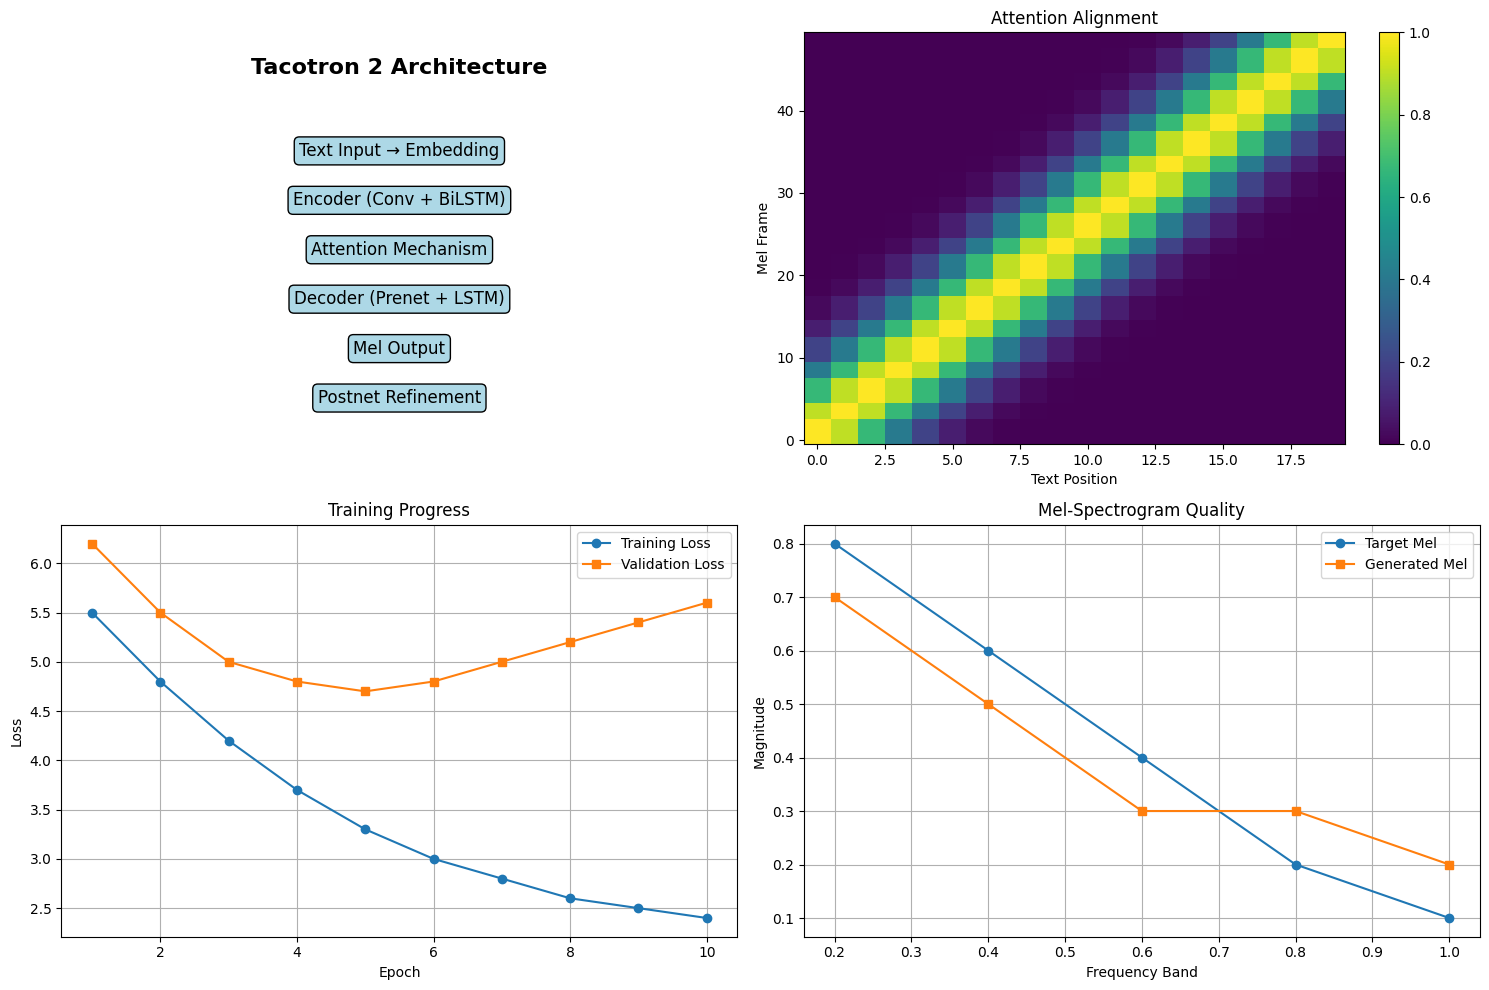

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def visualize_tacotron_training():
    """Visualize Tacotron 2 architecture and training"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Show Tacotron architecture
    components = [
        "Text Input → Embedding",
        "Encoder (Conv + BiLSTM)",
        "Attention Mechanism", 
        "Decoder (Prenet + LSTM)",
        "Mel Output",
        "Postnet Refinement"
    ]
    
    axes[0,0].text(0.5, 0.9, "Tacotron 2 Architecture", ha='center', fontsize=16, fontweight='bold')
    for i, comp in enumerate(components):
        y_pos = 0.7 - i * 0.12
        axes[0,0].text(0.5, y_pos, comp, ha='center', fontsize=12, 
                      bbox=dict(boxstyle="round", fc="lightblue"))
    axes[0,0].set_xlim(0, 1)
    axes[0,0].set_ylim(0, 1)
    axes[0,0].axis('off')
    
    # 2. Show attention alignment
    # Simulate attention weights
    text_len, mel_len = 20, 50
    attention = np.zeros((mel_len, text_len))
    for i in range(mel_len):
        center = int(i * text_len / mel_len)
        for j in range(text_len):
            attention[i, j] = np.exp(-0.1 * (j - center)**2)
    
    im = axes[0,1].imshow(attention, aspect='auto', origin='lower', cmap='viridis')
    axes[0,1].set_title("Attention Alignment")
    axes[0,1].set_xlabel("Text Position")
    axes[0,1].set_ylabel("Mel Frame")
    plt.colorbar(im, ax=axes[0,1])
    
    # 3. Show training losses
    epochs = range(1, 11)
    train_loss = [5.5, 4.8, 4.2, 3.7, 3.3, 3.0, 2.8, 2.6, 2.5, 2.4]
    val_loss = [6.2, 5.5, 5.0, 4.8, 4.7, 4.8, 5.0, 5.2, 5.4, 5.6]
    
    axes[1,0].plot(epochs, train_loss, 'o-', label='Training Loss')
    axes[1,0].plot(epochs, val_loss, 's-', label='Validation Loss')
    axes[1,0].set_title("Training Progress")
    axes[1,0].set_xlabel("Epoch")
    axes[1,0].set_ylabel("Loss")
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # 4. Show generated vs target mel
    axes[1,1].plot([0.2, 0.4, 0.6, 0.8, 1.0], [0.8, 0.6, 0.4, 0.2, 0.1], 'o-', label='Target Mel')
    axes[1,1].plot([0.2, 0.4, 0.6, 0.8, 1.0], [0.7, 0.5, 0.3, 0.3, 0.2], 's-', label='Generated Mel')
    axes[1,1].set_title("Mel-Spectrogram Quality")
    axes[1,1].set_xlabel("Frequency Band")
    axes[1,1].set_ylabel("Magnitude")
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

visualize_tacotron_training()